# Initialization
---
- example data (Heidi 2003 exampel data, 1 day Synechococcus)

In [15]:
setwd("/Users/francois/Documents/DATA/Codes/ssPopModel")


library(R.matlab)
library(seewave)
df <- readMat("inst/sosik2003/day733320data.mat") # load 1 day of observed Synechococcus size distribution (from SOSIK et al. 2003)

time <- seq(0,1+3600*24,by=3600)
volbins <- (df$volbins) 
V.hists <- df$Vhists
	colnames(V.hists) <- time
	row.names(V.hists) <- volbins
N.dist <- df$N.dist
	colnames(N.dist) <- time
	row.names(N.dist) <- volbins
	Ntot <- colSums(N.dist)
Edata <- df$Edata
	Edata[,1] <- seq(range(time)[1], range(time)[2], length.out=nrow(Edata))


results <- readMat("inst/sosik2003/results.mat") # load results (from SOSIK et al. 2003)
	Vproj <- results$Vproj
	colnames(Vproj) <- time
	row.names(Vproj) <- volbins

	params <- results$modelresults[-1]
	gmax <- params[1]
	a <- params[2]
	b <- params[3]
	E_star <- params[4]
	dmax <- params[5]
	c <- 1.5

	hr <- 1


######
library(DEoptim)
library(cmaes) 
        
        resol <- 10
		dt <- resol/60
		time.interval <- median(diff(as.numeric(colnames(V.hists))))
		# dt <- 1/6; breaks <- 25 ## MATLAB
		ti <- as.numeric(colnames(V.hists))

		# create Light data with 'dt' time interval.
			seq <- NULL
			for(i in 1:(length(ti)-1)){
				s <- seq(ti[i], ti[i+1], length.out=1/dt)
				seq <- c(seq, s)
			}

		ep <- data.frame(spline(Edata[,1], Edata[,2], xout=seq)) #interpolate E data according to dt resolution
		Einterp <- ep$y
		Einterp[Einterp < 0] <- 0

- $Sigma$ function for sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$


In [2]:
###############
## sigma.lsq ##
###############
# This function calculates the sum of squares of the of the differences between the hourly observations and the model given the specified parameters
# This function returns a column vector - called by "determine.opt.para" for the optimization.

	.sigma.lsq <- function(params, Einterp, N.dist, V.hists, resol){

				time.interval <- median(diff(as.numeric(colnames(V.hists))))
				res <- which(diff(as.numeric(colnames(V.hists))) == time.interval)# select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
				dim <- dim(N.dist)
				sigma <- matrix(NA, dim[1], dim[2]-1) # preallocate sigma
				TotN <- as.matrix(colSums(N.dist))
				volbins <- as.numeric(row.names(V.hists))

			for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=as.numeric(params[1]), dmax=as.numeric(params[2]), b=as.numeric(params[3]), E_star=as.numeric(params[4]),  c=as.numeric(params[5]), d=as.numeric(params[6]),resol=resol)
					wt <- B %*% V.hists[,hr] # calculate the projected size-frequency distribution
					wt.norm <- wt/sum(wt, na.rm=T) # normalize distribution
					sigma[,hr] <-  (N.dist[, hr+1] - round(TotN[hr+1]*wt.norm))^2 # ABSOLUTE observed value - fitted value
					}
			sigma <- colSums(sigma)/colSums(N.dist[,-1])
			sigma <- mean(sigma, na.rm=T)
			return(sigma)

}

- $Sigma$ function for Kullback-Leibler distance $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} y \ln(\frac{y}{\hat{y}})$

In [3]:
###############
## sigma.kl ##
###############
# This function calculates the sum of squares of the of the differences between the hourly observations and the model given the specified parameters
# This function returns a column vector - called by "determine.opt.para" for the optimization.

	.sigma.kl <- function(params, Einterp, N.dist, V.hists, resol){

				time.interval <- median(diff(as.numeric(colnames(V.hists))))
				res <- which(diff(as.numeric(colnames(V.hists))) == time.interval)# select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
				dim <- dim(N.dist)
				sigma <- matrix(NA, 1, dim[2]-1) # preallocate sigma
				TotN <- as.matrix(colSums(N.dist))
				volbins <- as.numeric(row.names(V.hists))

			for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=as.numeric(params[1]), dmax=as.numeric(params[2]), b=as.numeric(params[3]), E_star=as.numeric(params[4]),  c=as.numeric(params[5]), d=as.numeric(params[6]),resol=resol)
					wt <- B %*% V.hists[,hr] # calculate the projected size-frequency distribution
					wt.norm <- wt/sum(wt, na.rm=T) # normalize distribution
					sigma[,hr] <-  seewave::kl.dist(N.dist[, hr+1],round(TotN[hr+1]*wt.norm))$D1
                    }
			sigma <- sum(sigma, na.rm=T)
			return(sigma)

}


# 1. Original model
---

## 1a. Load matrix model

In [89]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, c, d, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 0 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
				# Assumptions:
				# 1) rate of respiration is a function of photosynthetic rate (gamma function)
				# 2) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)
		c <- 0
        resp <-  rep(mean(y) + 0.3, length(y)) # proportion of carbon storage to total carbon
		resp <- c * (resp - y) # transform to probability to decrease size over time period
		resp[which(resp < y)] <- 0 # probablity to decrease size class is 0 when growth rate > respiration rate

			# plot(y); points(resp,col=2); abline(h=c(mean(y), mean(resp)),col=c(1,2))
			# print(mean(resp)/mean(y))

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}

		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		#########################
		## ALLOMETRIC FUNCTION ## 
		#########################
		    # Based on Casey et al. L&O 2019
        allo <- (1+volbins)^-1.3 # allometric relationship of carbon metabolism
	    allo <- allo / sum(allo)
        allo <- d * allo / allo[round(m/2)] # allo = 1 at median (mid-range of size distribution) 
	
        allo <- rep(1,length(volbins)) # no allometric relationship

  
        ################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
		stasis_ind <- seq(1,m^2,by=m+1) # Diagonal stasis (0)
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal growth (-1)
		resp_ind <- seq(m+1, m^2, by=m+1) # superdiagonal (+1)
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal division (j-1)

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo

			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])*(1-respiration[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- A[1,1:(j-1)] + 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton

			# Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])*(1-gamma[-1])

					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

## 1b. Optimization 
- ### sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$

In [90]:
f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

    opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1,1e-6, 1e-6), upper=c(1,1,15,max(Einterp),15,10), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax <- params[1]
		dmax <- params[2]
		b <- params[3]
		E_star <- params[4]
		c <- params[5]
		d <- params[6]
		resnorm <- opt$optim$bestval

#    opt <- cma_es(par=c(0.1,0.1,1,1,1,1),f, lower=c(1e-6,1e-6,1e-6,1,1e-6, 1e-6), upper=c(1,1,15,max(Einterp),15,10), control=list(stopfitness=6.2))
#     	params <- opt$par
# 		gmax <- params[1]
# 		dmax <- params[2]
# 		b <- params[3]
# 		E_star <- params[4]
# 		c <- params[5]
# 		d <- params[6]
# 		resnorm <- opt$value


Iteration: 10 bestvalit: 5.989416 bestmemit:    0.119595    0.020586    5.346707  365.405070    5.710758    2.266968
Iteration: 20 bestvalit: 5.141366 bestmemit:    0.142692    0.025445    3.860703  256.940160    1.825089    6.645180
Iteration: 30 bestvalit: 5.039443 bestmemit:    0.151914    0.036649    4.303816  251.645019    3.433742    5.886446
Iteration: 40 bestvalit: 5.002329 bestmemit:    0.169879    0.036432    3.832087  244.370922    3.868888    4.369732
Iteration: 50 bestvalit: 4.985430 bestmemit:    0.171915    0.036930    4.042451  246.465381    0.163170    5.649212
Iteration: 60 bestvalit: 4.978646 bestmemit:    0.164352    0.035499    4.042195  244.123679   12.584533    2.927078
Iteration: 70 bestvalit: 4.977661 bestmemit:    0.168007    0.038115    4.059832  246.002454    4.711005    1.874562
Iteration: 80 bestvalit: 4.974988 bestmemit:    0.167398    0.036897    4.040906  245.696705    7.060798    6.146774
Iteration: 90 bestvalit: 4.974988 bestmemit:    0.167398    0.03

- ### Kullback-Leibler distance $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} y \ln(\frac{y}{\hat{y}})$

In [91]:
f <- function(params) .sigma.kl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

    opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1,1e-6, 1e-6), upper=c(1,1,15,max(Einterp),15,10), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax. <- params[1]
		dmax. <- params[2]
		b. <- params[3]
		E_star. <- params[4]
		c. <- params[5]
		d. <- params[6]
		resnorm. <- opt$optim$bestval

#    opt <- cma_es(par=c(0.1,0.1,1,1,1,1),f, lower=c(1e-6,1e-6,1e-6,1,1e-6, 1e-6), upper=c(1,1,15,max(Einterp),15,10), control=list(stopfitness=5))
#     	params <- opt$par
# 		gmax. <- params[1]
# 		dmax. <- params[2]
# 		b. <- params[3]
# 		E_star. <- params[4]
# 		c. <- params[5]
# 		d. <- params[6]
# 		resnorm. <- opt$value


Iteration: 10 bestvalit: 0.262169 bestmemit:    0.179642    0.043268    3.667269   39.555641   13.905923    5.499982
Iteration: 20 bestvalit: 0.240071 bestmemit:    0.202053    0.047368    4.042603  265.823736   10.143998    6.350476
Iteration: 30 bestvalit: 0.230770 bestmemit:    0.179642    0.033842    3.897754  248.869632    2.375592    5.499982
Iteration: 40 bestvalit: 0.230169 bestmemit:    0.171224    0.033842    3.897754  258.258421   14.393717    5.499982
Iteration: 50 bestvalit: 0.230169 bestmemit:    0.171224    0.033842    3.897754  258.258421   14.393717    6.126656
Iteration: 60 bestvalit: 0.230030 bestmemit:    0.173732    0.032640    3.904744  256.476115    0.509838    0.998947
Iteration: 70 bestvalit: 0.229915 bestmemit:    0.172071    0.032546    3.876855  263.263953   11.519789    7.646180
Iteration: 80 bestvalit: 0.229845 bestmemit:    0.169959    0.032208    3.849713  259.143649    6.865209    0.713904
Iteration: 90 bestvalit: 0.229845 bestmemit:    0.169959    0.03

## 1c. Results

In [92]:
####################################################
## Calculate projections from best fit parameters ##
####################################################
library(ggplot2)
library(reshape2)
res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
Vproj <- Vproj. <- V.hists
Nproj <- Nproj. <- N.dist
mu_N <- mu_N. <- matrix(nrow=1,ncol=dim(V.hists)[2])
volbins <- as.numeric(row.names(V.hists))

for(hr in res){
		B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax, dmax=dmax,b=b, E_star=E_star,c=c, d=d, resol=resol)
        Nproj[,hr+1] <- round(B %*% Nproj[,hr]) # calculate numbers of individuals
	    Vproj[,hr+1] <- B %*% Vproj[,hr] # calculate the projected size-frequency distribution
		Vproj[,hr+1] <- Vproj[,hr+1]/sum(Vproj[,hr+1]) # normalize distribution so sum = 1
		mu_N[,hr+1] <- log(sum(Nproj[,hr+1])/sum(Nproj[,hr]))/
					    ((as.numeric(colnames(Nproj)[hr+1])-as.numeric(colnames(Nproj)[hr]))/(time.interval))
            		    
      B. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax., dmax=dmax.,b=b., E_star=E_star.,c=c., d=d., resol=resol)
      Nproj.[,hr+1] <- round(B. %*% Nproj.[,hr]) # calculate numbers of individuals
      Vproj.[,hr+1] <- B. %*% Vproj.[,hr] # calculate the projected size-frequency distribution
	    Vproj.[,hr+1] <- Vproj.[,hr+1]/sum(Vproj.[,hr+1]) # normalize distribution so sum = 1
		mu_N.[,hr+1] <- log(sum(Nproj.[,hr+1])/sum(Nproj.[,hr]))/
					    ((as.numeric(colnames(Nproj.)[hr+1])-as.numeric(colnames(Nproj.)[hr]))/(time.interval))
				
    }

Nproj <- colSums(Nproj)
colnames(mu_N) <- colnames(Vproj)
Nproj. <- colSums(Nproj.)
colnames(mu_N.) <- colnames(Vproj.)

#############################
## Growth rate calculation ##
#############################
d.mu_N <- 24*mean(mu_N[-c(1:2)], na.rm=T)
d.mu_N. <- 24*mean(mu_N.[-c(1:2)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N,2),"-",round(d.mu_N.,2)))


[1] "daily growth rate= 0.75 - 0.72"


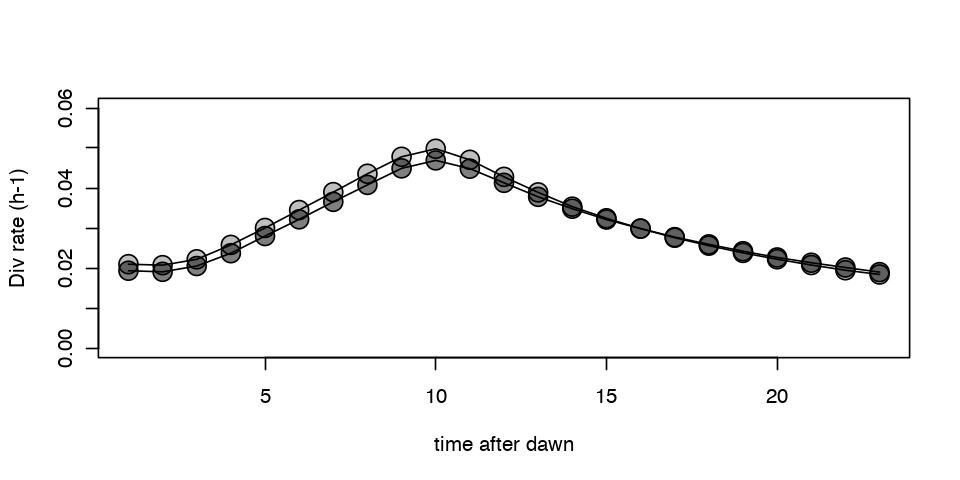

In [110]:
options(repr.plot.width=8, repr.plot.height=4)
plot(mu_N[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.25))
    points(mu_N.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(1,0.5))

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

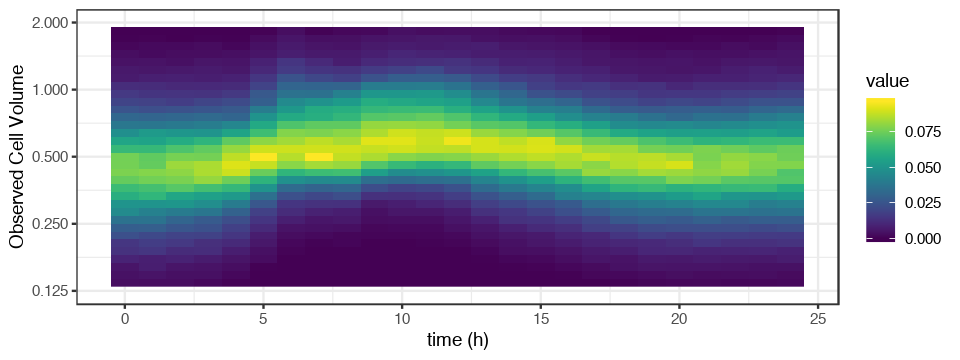

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

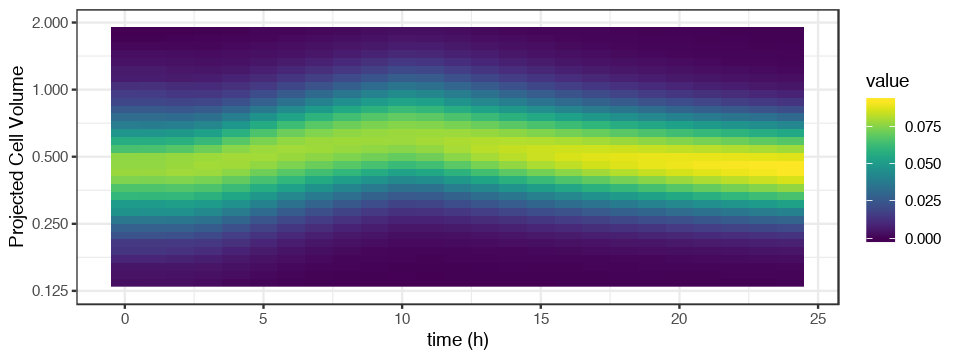

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

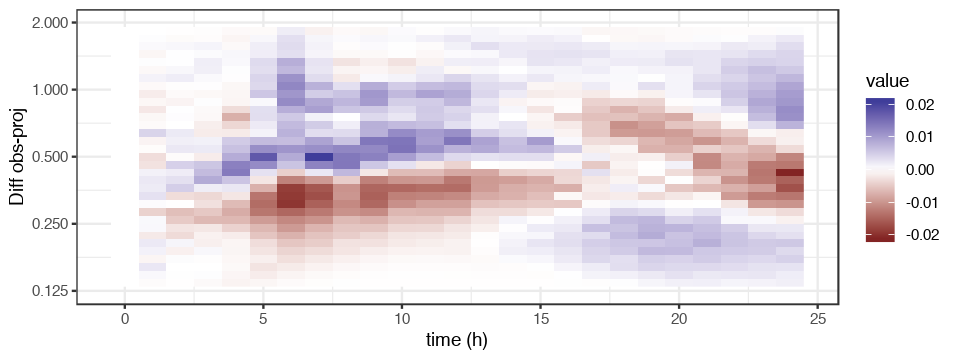

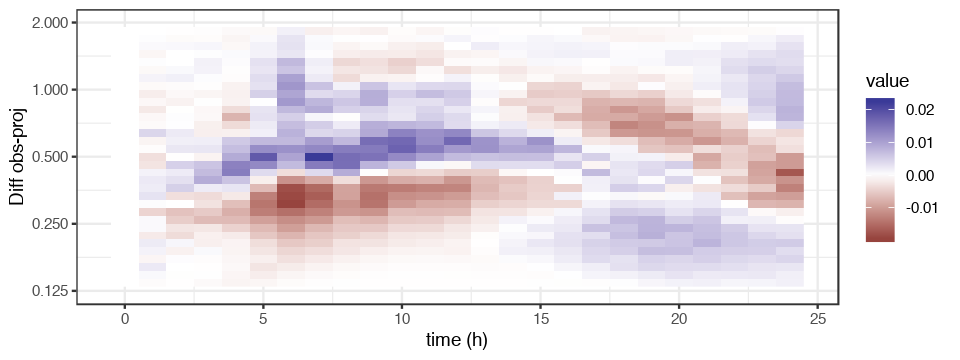

In [121]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
ggplot(melt(Vproj), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Projected Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
ggplot(melt(V.hists- Vproj), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj') + scale_fill_gradient2(midpoint=0)
ggplot(melt(V.hists- Vproj.), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj') +  scale_fill_gradient2(midpoint=0)

# 2. Model with Respiration
---


## 2a. Load matrix model

In [127]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, c, d, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 0 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
				# Assumptions:
				# 1) rate of respiration is a function of photosynthetic rate (gamma function)
				# 2) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)
		c <- 1
        resp <-  rep(mean(y) * 0.3, length(y)) # proportion of carbon storage to total carbon
		resp <- c * (resp - y) # transform to probability to decrease size over time period
		resp[which(resp < y)] <- 0 # probablity to decrease size class is 0 when growth rate > respiration rate

			# plot(y); points(resp,col=2); abline(h=c(mean(y), mean(resp)),col=c(1,2))
			# print(mean(resp)/mean(y))

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}

		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		#########################
		## ALLOMETRIC FUNCTION ## 
		#########################
		    # Based on Casey et al. L&O 2019
    	allo <-  (1+volbins)^-1.3 # allometric relationship of carbon metabolism
	    allo <- allo / sum(allo)
        allo <- allo / allo[round(m/2)] # allo = 1 at median (mid-range of size distribution) 
	
        allo <- rep(1,length(volbins)) # no allometric relationship

  
        ################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
		stasis_ind <- seq(1,m^2,by=m+1) # Diagonal stasis (0)
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal growth (-1)
		resp_ind <- seq(m+1, m^2, by=m+1) # superdiagonal (+1)
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal division (j-1)

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo
			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])*(1-respiration[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- A[1,1:(j-1)] + 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton

			# Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])*(1-gamma[-1])

					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

## 2b. Optimization
- ### sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$

In [128]:
f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1,1e-6,1e-6), upper=c(1,1,15,max(Einterp),15,15), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax2 <- params[1]
		dmax2 <- params[2]
		b2 <- params[3]
		E_star2 <- params[4]
		c2 <- params[5]
		d2 <- params[6]
		resnorm2 <- opt$optim$bestval

- ### Kullback-Leibler distance $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} y \ln(\frac{y}{\hat{y}})$

In [97]:
f <- function(params) .sigma.kl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1,1e-6,1e-6), upper=c(1,1,15,max(Einterp),15,15), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax2. <- params[1]
		dmax2. <- params[2]
		b2. <- params[3]
		E_star2. <- params[4]
		c2. <- params[5]
		d2. <- params[6]
		resnorm2. <- opt$optim$bestval

Iteration: 10 bestvalit: 0.253355 bestmemit:    0.200027    0.056828    5.225769  259.900555   13.174158    8.039631
Iteration: 20 bestvalit: 0.227893 bestmemit:    0.171742    0.037416    4.154253  177.728665    9.973450    4.104211
Iteration: 30 bestvalit: 0.223169 bestmemit:    0.157828    0.029431    4.537078  257.394570   13.087186    5.010610
Iteration: 40 bestvalit: 0.221779 bestmemit:    0.167073    0.031876    4.264622  252.373516   13.215728   13.144579
Iteration: 50 bestvalit: 0.221380 bestmemit:    0.164727    0.029367    4.206419  257.620795   12.084625   14.281146
Iteration: 60 bestvalit: 0.221268 bestmemit:    0.165792    0.029367    4.206419  257.620795    6.320126   10.994941
Iteration: 70 bestvalit: 0.221018 bestmemit:    0.164863    0.029677    4.140533  255.022286    9.058983    6.033045
Iteration: 80 bestvalit: 0.221016 bestmemit:    0.164863    0.029519    4.139982  255.022286    9.058983   14.895770
Iteration: 90 bestvalit: 0.220997 bestmemit:    0.164863    0.02

## 2c. Results

In [99]:
####################################################
## Calculate projections from best fit parameters ##
####################################################
library(ggplot2)
library(reshape2)
res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
Vproj2 <- Vproj2. <- V.hists
Nproj2 <- Nproj2. <- N.dist
mu_N2 <- mu_N2. <- matrix(nrow=1,ncol=dim(V.hists)[2])
volbins <- as.numeric(row.names(V.hists))

for(hr in res){
	B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax2, dmax=dmax2,b=b2, E_star=E_star2,c=c2, d=d2, resol=resol)
    Nproj2[,hr+1] <- round(B %*% Nproj2[,hr]) # calculate numbers of individuals
	Vproj2[,hr+1] <- B %*% Vproj2[,hr] # calculate the projected size-frequency distribution
	Vproj2[,hr+1] <- Vproj2[,hr+1]/sum(Vproj2[,hr+1]) # normalize distribution so sum = 1
	mu_N2[,hr+1] <- log(sum(Nproj2[,hr+1])/sum(Nproj2[,hr]))/
					((as.numeric(colnames(Nproj2)[hr+1])-as.numeric(colnames(Nproj2)[hr]))/(time.interval))
            		    
  B. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax2., dmax=dmax2.,b=b2., E_star=E_star2.,c=c2., d=d2., resol=resol)
  Nproj2.[,hr+1] <- round(B. %*% Nproj2.[,hr]) # calculate numbers of individuals
	Vproj2.[,hr+1] <- B. %*% Vproj2.[,hr] # calculate the projected size-frequency distribution
	Vproj2.[,hr+1] <- Vproj2.[,hr+1]/sum(Vproj2.[,hr+1]) # normalize distribution so sum = 1
	mu_N2.[,hr+1] <- log(sum(Nproj2.[,hr+1])/sum(Nproj2.[,hr]))/
					((as.numeric(colnames(Nproj2.)[hr+1])-as.numeric(colnames(Nproj2.)[hr]))/(time.interval))
						
    }

Nproj2 <- colSums(Nproj2)
colnames(mu_N2) <- colnames(Vproj2)
Nproj2. <- colSums(Nproj2.)
colnames(mu_N2.) <- colnames(Vproj2.)

#############################
## Growth rate calculation ##
#############################
d.mu_N2 <- 24*mean(mu_N2[-c(1:2)], na.rm=T)
d.mu_N2. <- 24*mean(mu_N2.[-c(1:2)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N2,2),"-",round(d.mu_N2.,2)))

[1] "daily growth rate= 0.63 - 0.63"


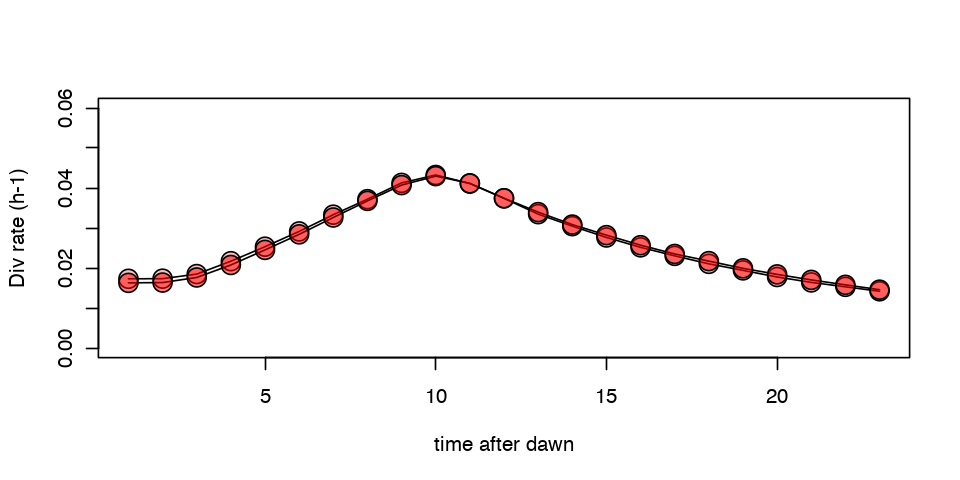

In [100]:
options(repr.plot.width=8, repr.plot.height=4)
plot(mu_N2[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(2,0.25))
    points(mu_N2.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(2,0.5))

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

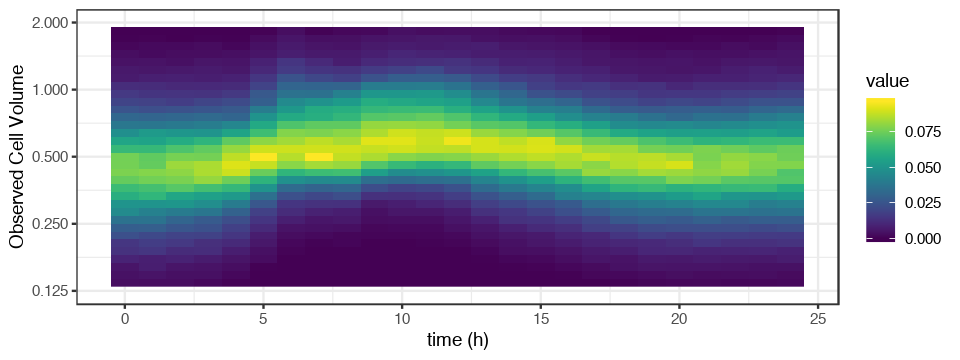

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

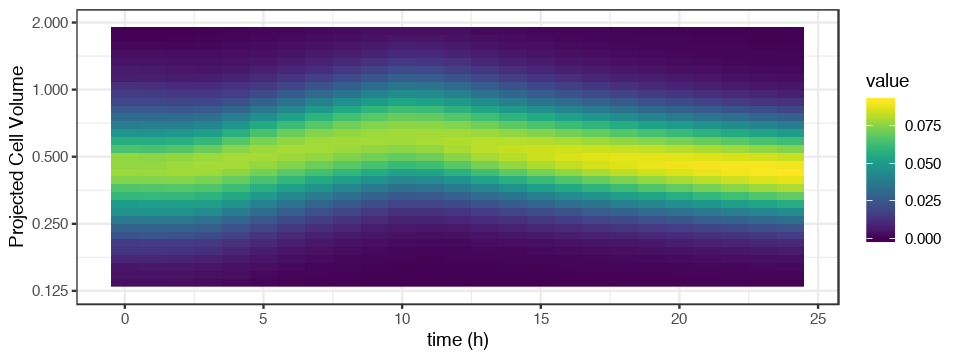

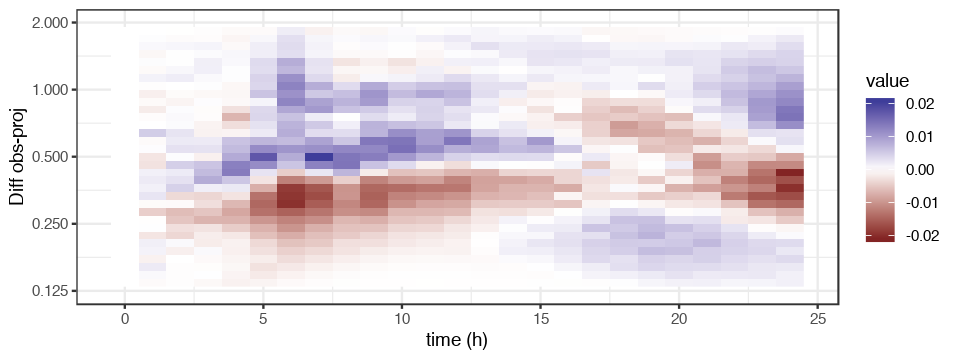

In [122]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
ggplot(melt(Vproj2), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Projected Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
ggplot(melt(V.hists-Vproj2), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj') + scale_fill_gradient2(midpoint=0)

# 3 Model with Respiration + Allometric functions
---

## 3a. Load matrix model

In [84]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, c, d, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 0 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
				# Assumptions:
				# 1) rate of respiration is a function of photosynthetic rate (gamma function)
				# 2) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)
		c <- 1
        resp <-  rep(mean(y) + 0.3, length(y)) # proportion of carbon storage to total carbon
		resp <- c * (resp - y) # transform to probability to decrease size over time period
		resp[which(resp < y)] <- 0 # probablity to decrease size class is 0 when growth rate > respiration rate

			# plot(y); points(resp,col=2); abline(h=c(mean(y), mean(resp)),col=c(1,2))
			# print(mean(resp)/mean(y))

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}

		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		#########################
		## ALLOMETRIC FUNCTION ## 
		#########################
		    # Based on Casey et al. L&O 2019
  	        #d <- 0
      	allo <-  (volbins)^-1.3 # allometric relationship of carbon metabolism
        allo[which(allo > 5)] <- 5      
         # allo <- rep(1,length(volbins)) # no allometric relationship
  
        ################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
		stasis_ind <- seq(1,m^2,by=m+1) # Diagonal stasis (0)
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal growth (-1)
		resp_ind <- seq(m+1, m^2, by=m+1) # superdiagonal (+1)
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal division (j-1)

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*rep(1,length(volbins))

			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])*(1-respiration[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- A[1,1:(j-1)] + 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton

			# Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])*(1-gamma[-1])

					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

## 3b. Optimization
- ### sum of squared residuals $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} (y - \hat{y})^2$

In [85]:
	f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1,1e-6,1e-6), upper=c(1,1,15,max(Einterp),15,15), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax3 <- params[1]
		dmax3 <- params[2]
		b3 <- params[3]
		E_star3 <- params[4]
		c3 <- params[5]
		d3 <- params[6]
		resnorm3 <- opt$optim$bestval

Iteration: 10 bestvalit: 50.988069 bestmemit:    0.086969    0.046055   13.530730  137.444046    0.389238   12.290798
Iteration: 20 bestvalit: 43.092248 bestmemit:    0.072898    0.002752   13.667861   24.834205    5.989321   14.684972
Iteration: 30 bestvalit: 41.237386 bestmemit:    0.077198    0.004671   14.240032    4.248921   12.772690    9.831954
Iteration: 40 bestvalit: 40.994052 bestmemit:    0.080524    0.003211   13.632987    1.595779    6.516643   10.030826
Iteration: 50 bestvalit: 40.746763 bestmemit:    0.077856    0.000229   12.982956    2.023664    7.595300    3.769095
Iteration: 60 bestvalit: 40.707447 bestmemit:    0.075962    0.000108   14.377520    1.627556    8.025762   11.479982
Iteration: 70 bestvalit: 40.696162 bestmemit:    0.077150    0.000015   14.490004    1.632614    0.969593    7.245774
Iteration: 80 bestvalit: 40.690894 bestmemit:    0.076981    0.000034   13.777504    1.838372   14.068200    5.335231
Iteration: 90 bestvalit: 40.689101 bestmemit:    0.07684

- ### Kullback-Leibler distance $Resid = \sum_{i=1}^{24} \sum_{i=1}^{n} y \ln(\frac{y}{\hat{y}})$

In [75]:
f <- function(params) .sigma.kl(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1,1e-6,1e-6), upper=c(1,1,15,max(Einterp),15,15), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax3. <- params[1]
		dmax3. <- params[2]
		b3. <- params[3]
		E_star3. <- params[4]
		c3. <- params[5]
		d3. <- params[6]
		resnorm3. <- opt$optim$bestval

ERROR: Error in seewave::kl.dist(N.dist[, hr + 1], round(TotN[hr + 1] * wt.norm)): Data do not have to be in dB


## 3c. Results

In [86]:
####################################################
## Calculate projections from best fit parameters ##
####################################################
library(ggplot2)
library(reshape2)
print(params)

res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
Vproj3 <- Vproj3. <- V.hists
Nproj3 <- Nproj3. <- N.dist
mu_N3 <- mu_N3. <- matrix(nrow=1,ncol=dim(V.hists)[2])
volbins <- as.numeric(row.names(V.hists))

for(hr in res){
	B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax3, dmax=dmax3,b=b3, E_star=E_star3,c=c3, d=d3, resol=resol)
    Nproj3[,hr+1] <- round(B %*% Nproj3[,hr]) # calculate numbers of individuals
	Vproj3[,hr+1] <- B %*% Vproj3[,hr] # calculate the projected size-frequency distribution
	Vproj3[,hr+1] <- Vproj3[,hr+1]/sum(Vproj3[,hr+1]) # normalize distribution so sum = 1
	mu_N3[,hr+1] <- log(sum(Nproj3[,hr+1])/sum(Nproj3[,hr]))/
					((as.numeric(colnames(Nproj3)[hr+1])-as.numeric(colnames(Nproj3)[hr]))/(time.interval))
            		    
#   B. <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax3., dmax=dmax3.,b=b3., E_star=E_star3.,c=c3., d=d3., resol=resol)
#   Nproj3.[,hr+1] <- round(B. %*% Nproj3.[,hr]) # calculate numbers of individuals
# 	Vproj3.[,hr+1] <- B. %*% Vproj3.[,hr] # calculate the projected size-frequency distribution
# 	Vproj3.[,hr+1] <- Vproj3.[,hr+1]/sum(Vproj3.[,hr+1]) # normalize distribution so sum = 1
# 	mu_N3.[,hr+1] <- log(sum(Nproj3.[,hr+1])/sum(Nproj3.[,hr]))/
# 					((as.numeric(colnames(Nproj3.)[hr+1])-as.numeric(colnames(Nproj3.)[hr]))/(time.interval))
						
    }

Nproj3 <- colSums(Nproj3)
colnames(mu_N3) <- colnames(Vproj3)
# Nproj3. <- colSums(Nproj3.)
# colnames(mu_N3.) <- colnames(Vproj3.)
		
#############################
## Growth rate calculation ##
#############################
d.mu_N3 <- 24*mean(mu_N3[-c(1:2)], na.rm=T)
# d.mu_N3. <- 24*mean(mu_N3.[-c(1:2)], na.rm=T)

print(paste("daily growth rate=",round(d.mu_N3,2)))#,"-",round(d.mu_N3.,2)))

        par1         par2         par3         par4         par5         par6 
7.680428e-02 2.535958e-05 1.402984e+01 1.366924e+00 4.164143e+00 1.480125e+01 
[1] "daily growth rate= -4.13"


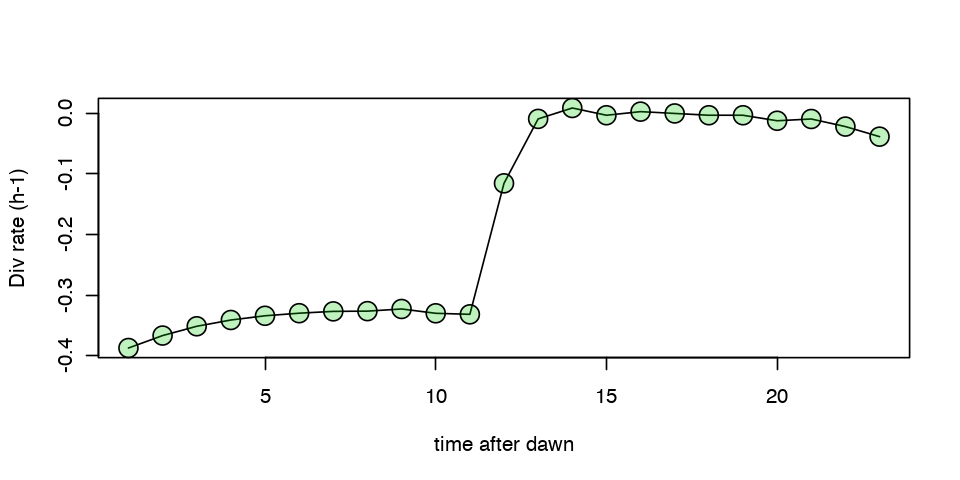

In [87]:
options(repr.plot.width=8, repr.plot.height=4)
plot(mu_N3[-c(1:2)],type='o', xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(3,0.25))
#     points(mu_N3.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(3,0.5))

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

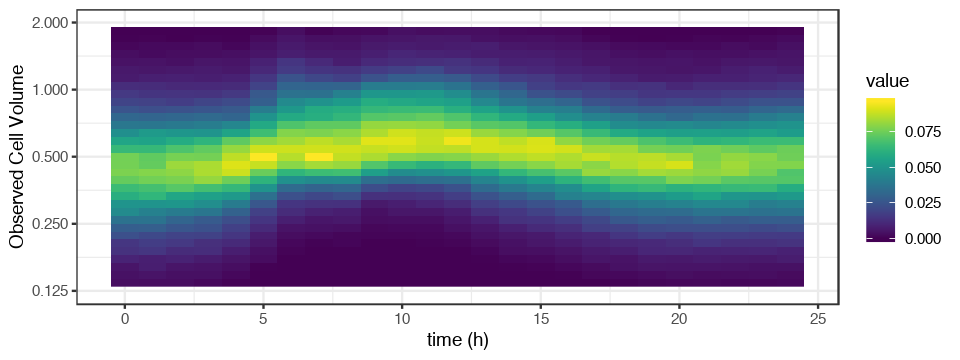

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

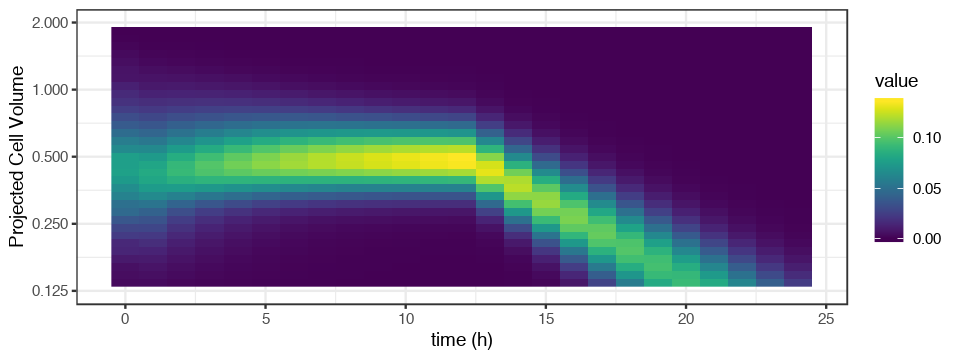

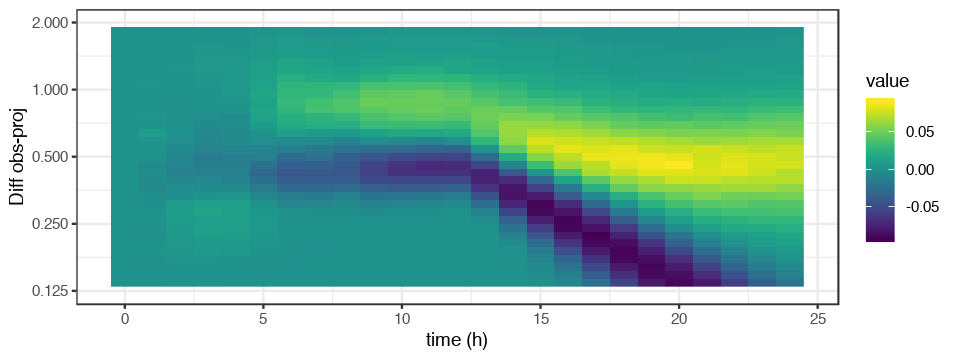

In [88]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(V.hists), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Observed Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
ggplot(melt(Vproj3), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Projected Cell Volume') + scale_fill_gradientn(colors=viridis::viridis(100))
ggplot(melt(V.hists - Vproj3), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj') + scale_fill_gradientn(colors=viridis::viridis(100))

# 4. Summary
---

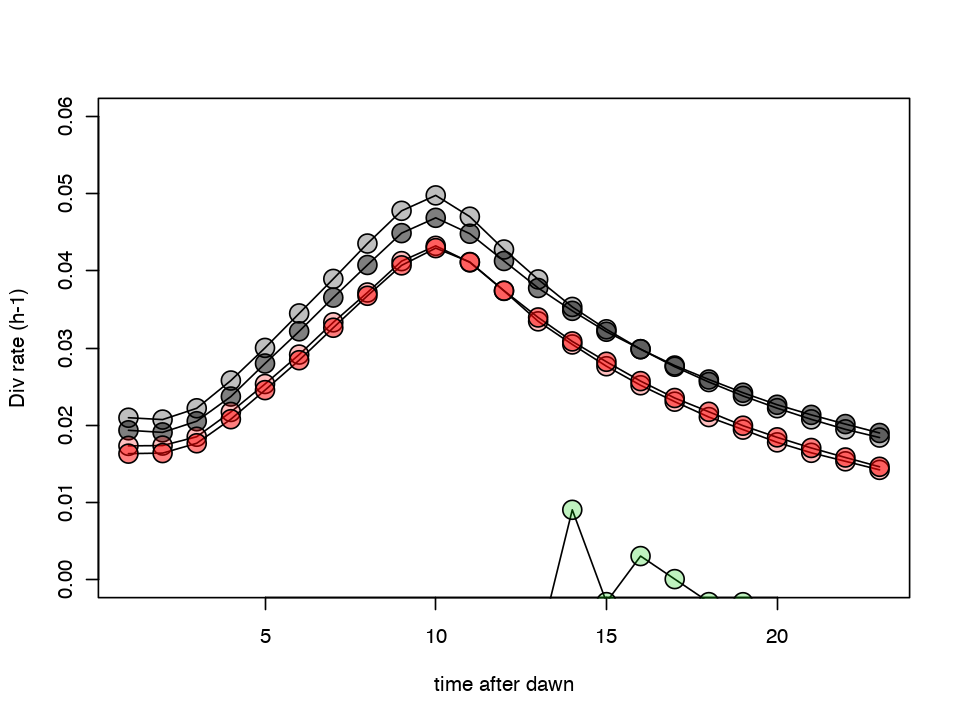

In [111]:
options(repr.plot.width=8, repr.plot.height=6)
plot(mu_N[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.25))
    points(mu_N.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(1,0.5))
  points(mu_N2[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(2,0.25))
    points(mu_N2.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(2,0.5))
  points(mu_N3[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(3,0.25))
  #  points(mu_N3.[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(3,0.5))


Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

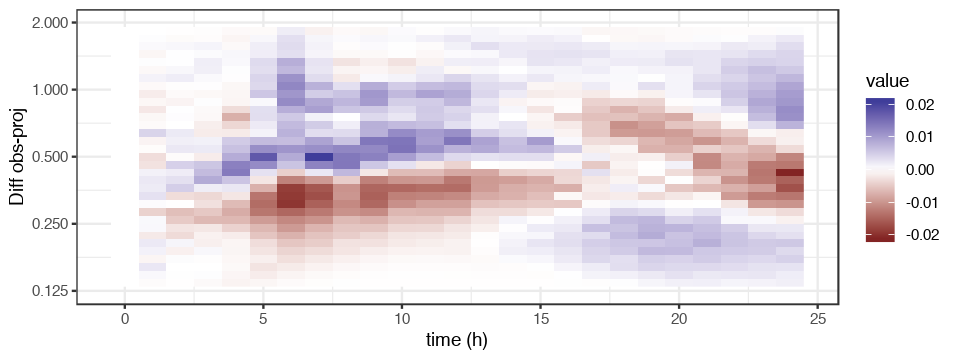

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

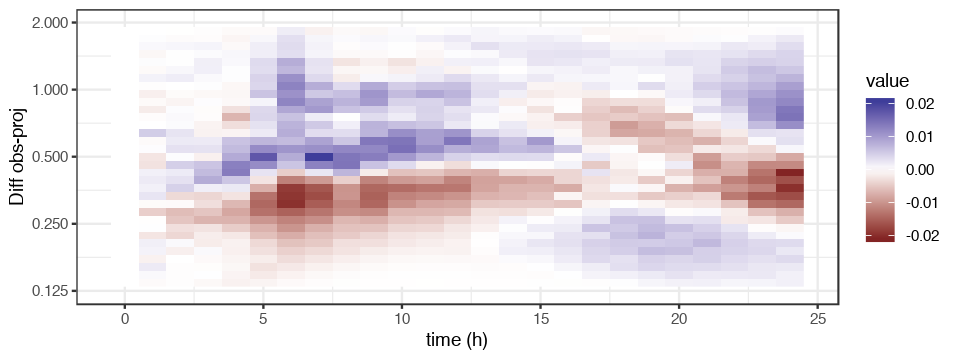

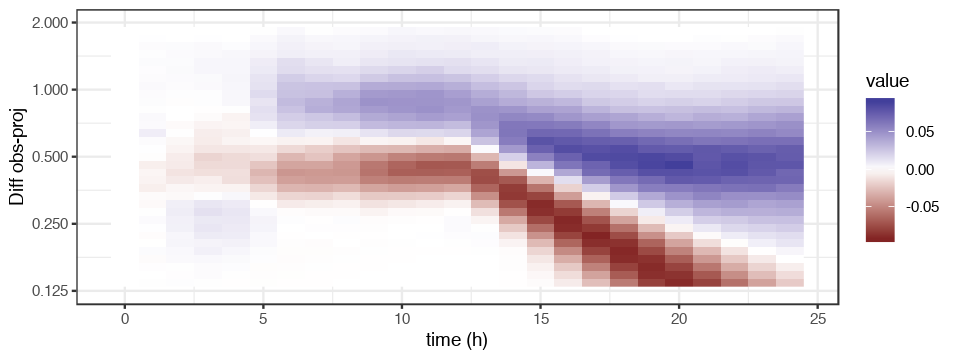

In [123]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(V.hists - Vproj), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj') + scale_fill_gradient2(midpoint=0)
ggplot(melt(V.hists - Vproj2), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj') + scale_fill_gradient2(midpoint=0)
ggplot(melt(V.hists - Vproj3), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj') + scale_fill_gradient2(midpoint=0)

Warning message:
"Removed 600 rows containing missing values (geom_raster)."Warning message:
"Removed 600 rows containing missing values (geom_raster)."

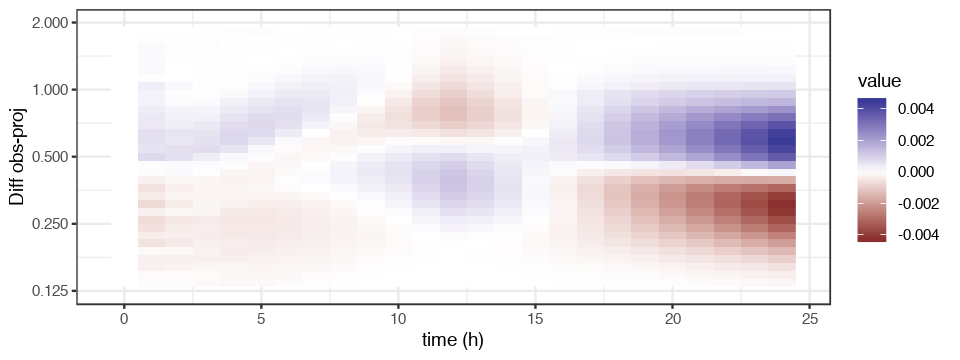

Warning message:
"Removed 600 rows containing missing values (geom_raster)."

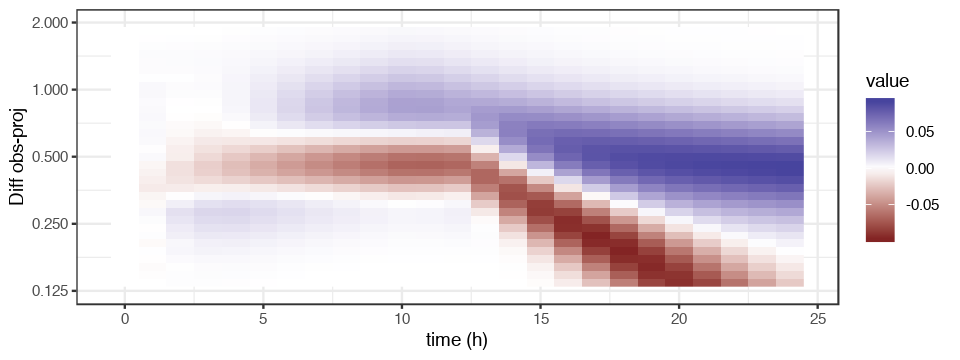

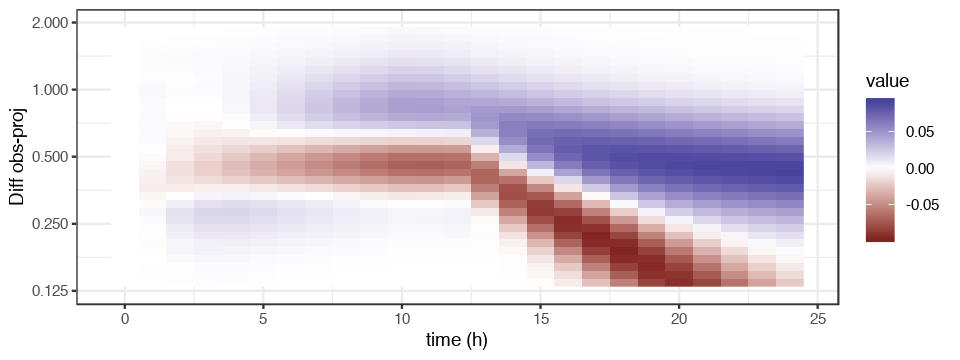

In [124]:
options(repr.plot.width=8, repr.plot.height=3)
ggplot(melt(Vproj - Vproj2), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj') + scale_fill_gradient2(midpoint=0)
ggplot(melt(Vproj - Vproj3), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj') + scale_fill_gradient2(midpoint=0)
ggplot(melt(Vproj2 - Vproj3), aes(Var2/3600,Var1, fill=value)) + geom_raster() + scale_y_continuous(trans='log2',limits = c(0.125, 2)) + theme_bw() + labs(x='time (h)', y= 'Diff obs-proj') + scale_fill_gradient2(midpoint=0)
